<a href="https://colab.research.google.com/github/ssamadjon3106/PyTorch-with-Deep-Learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d83f306b5c0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(1))

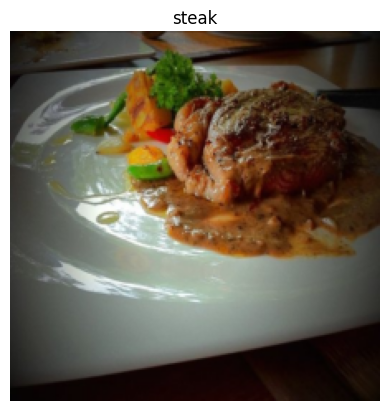

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [9]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [10]:

# Redefine the PatchEmbedding class with the fix
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int=3, patch_size: int=16, emb_size: int=768):
    super().__init__()
    self.patch_size = patch_size # Store patch_size for the assert
    self.patcher=nn.Conv2d(in_channels=in_channels, out_channels=emb_size, kernel_size=patch_size, stride=patch_size, padding=0)
    self.flatten=nn.Flatten(start_dim=2, end_dim=3) # Flattens the H and W dimensions from (B, C, H, W) to (B, C, H*W)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Image size ({image_resolution}) must be divisible by patch size ({self.patch_size})"

    # Apply convolution to get patch embeddings
    patched_x = self.patcher(x) # Shape: (B, emb_size, H_patches, W_patches) e.g., (1, 768, 14, 14)

    # Flatten the spatial dimensions (H_p, W_p) into a single dimension
    flattened_patches = self.flatten(patched_x) # Shape: (B, emb_size, H_p*W_p) e.g., (1, 768, 196)

    # Permute to get (B, H_p*W_p, emb_size) which is (B, num_patches, embedding_dimension)
    final_output = flattened_patches.permute(0, 2, 1) # Shape: (1, 196, 768)
    return final_output

In [11]:
#create multi-head attention

class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, num_heads:int=12, attn_dropout=0):
    super().__init__()
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    #creae

    self.multi_head_attention=nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)
  def forward(self, x):
    x=self.layer_norm(x)
    attn_output, _ =self.multi_head_attention(query=x, key=x, value=x, need_weights=False)
    return attn_output



In [12]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout:int =0.1):
    super().__init__()
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp=nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size), # Changed out_features to mlp_size
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, # Changed in_features to mlp_size
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )
  def forward(self, x):
    x=self.layer_norm(x)
    x=self.mlp(x)
    return x

In [13]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, dropout: int=0.01, mlp_size: int =3072, num_heads: int=12, attn_dropout: int=0):
    super().__init__()
    self.msa_block=MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
    self.mlp_block=MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=dropout)

  def forward(self, x):
    x=x+self.msa_block(x)
    x=x+self.mlp_block(x)
    return x


In [14]:
transformer_encoder_block=TransformerEncoderBlock()

summary(model=transformer_encoder_block, input_size=(1, 197, 768), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])
#transformer_encoder_block_output=transformer_encoder_block(patch_image_through_mlp_block)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multi_head_attention)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [15]:
torch_transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, activation='gelu', dropout=0.1,batch_first=True, norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [16]:
# Create ViT class
class ViT(nn.Module):
  def __init__(self, image_size: int=224, in_channels: int=3, patch_size: int=16, num_transformer_layers:int=12, embedding_dim: int=768, mlp_size:int =3072, num_heads: int=12 , attn_dropout: int=0, mlp_dropout: int=0.1, embedding_dropout: int=0.1, num_classes: int=1000):
    super().__init__()
    assert image_size%patch_size==0,  f'Image size must be divisible by patch size'

    # calculate num_patches
    self.num_patches=(image_size * image_size)//patch_size**2

    self.class_embdedding=nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)

    self.position_embedding=nn.Parameter(torch.randn(1, self.num_patches+1, embedding_dim))

    #emdedding dropout
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    # patch embedding dropout
    self.patch_embedding=PatchEmbedding(in_channels=in_channels, patch_size=patch_size, emb_size=embedding_dim)

    # create transformer block

    self.transformer_encoder=nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, # Hidden size D from Table 1 for ViT-Base
                 num_heads=num_heads, # Heads from Table 1 for ViT-Base
                 mlp_size=mlp_size, # MLP size from Table 1 for ViT-Base
                 dropout=mlp_dropout, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])
    # MLP head
    self.classifier=nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    batch_size=x.shape[0]
    class_token=self.class_embdedding.expand(batch_size, -1, -1)

    x=self.patch_embedding(x)
    x=torch.cat((class_token, x), dim=1)
    x=x+self.position_embedding
    x=self.embedding_dropout(x)
    x=self.transformer_encoder(x)
    x=self.classifier(x[:,0])
    return x

In [17]:
%%writefile vit.py
import torch
from torch import nn

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

Overwriting vit.py


## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [18]:
import torchvision
vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit=torchvision.models.vit_b_16(weights=vit_weights).to(device)
for param in pretrained_vit.parameters():
  param.requires_grad=False
pretrained_vit.heads=nn.Sequential(
    nn.LayerNorm(normalized_shape=768),
    nn.Linear(in_features=768, out_features=len(class_names))
)

summary(pretrained_vit,input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [19]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, test_dir=test_dir, # use 10% data for testing
                                                                                           transform=vit_transforms,
                                                                                           batch_size=32)


[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [20]:
len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader)

(8, 15, 3)

In [21]:
# Train a pretrained ViT feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Examine results
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# TODO: your code

vit_weights_swag=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_vit_swag=torchvision.models.vit_b_16(weights=vit_weights_swag)


for param in pretrained_vit_swag.parameters():
  param.requires_grad=False
pretrained_vit_swag.heads=nn.Sequential(
    nn.LayerNorm(normalized_shape=768),
    nn.Linear(in_features=768, out_features=len(class_names))
)
summary(model=pretrained_vit_swag, input_size=(1, 3, 384, 384),# col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
vit_transforms_swag_transforms = vit_weights_swag.transforms() # get transforms from vit_weights_swag
vit_transforms_swag_tarnsforms

In [ ]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=vit_transforms_swag,
                                                                                          batch_size=32)

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_swag_results)

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

In [ ]:
# TODO: your explanations of the above terms